# Comparative Analysis of CNN and Transfer Learning for Flower Image Classification

This notebook investigates the impact of transfer learning on image classification performance under limited data conditions.

We compare:
- A custom CNN trained from scratch
- A pretrained DenseNet121 model fine-tuned on the target dataset

The objective is to analyze generalization behavior rather than only final accuracy.

# I- Data preparation 

## 1. Data load 

In [2]:
#Imports and Configuration

from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

In [3]:
# Detect project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "jpg"

if not DATA_DIR.exists():
    raise FileNotFoundError(f"{DATA_DIR} introuvable.")

print("Chargement des données depuis :", DATA_DIR)


Chargement des données depuis : /Users/admin/Desktop/flower-image-classification/data/jpg


In [4]:
# Load datasets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes :", class_names)



Found 320 files belonging to 4 classes.
Using 256 files for training.
Found 320 files belonging to 4 classes.
Using 64 files for validation.
Classes : ['0', '2', '4', '9']


In [5]:
# Optimize input pipeline
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 2. Data augmentation 

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# II-Baseline CNN

## 1. Architecture and Training




We design a VGG-style convolutional network with increasing channel depth.

The architecture progressively increases feature dimensionality
(64 → 128 → 256 filters) while reducing spatial resolution through max pooling.

Global average pooling is used instead of flattening to reduce parameter count
and mitigate overfitting in a low-data regime.

The model was designed to satisfy the constraint of having between 1 and 3 million parameters.  
However, the experimental results suggest that a more compact network achieves better validation performance.

This observation highlights that, in a limited data regime, model capacity must be carefully controlled. An overly complex network tends to overfit quickly, even when regularization techniques such as dropout and batch normalization are applied.


In [6]:
model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize pixel values to [0,1]
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # ---------------- Block 1 ----------------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 2 ----------------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 3 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 4 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Global pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Classification head
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,282,628 (4.89 MB)

 Trainable params: 1,280,836 (4.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6484 - loss: 0.8468 - val_accuracy: 0.3281 - val_loss: 1.4832
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7773 - loss: 0.5891 - val_accuracy: 0.4531 - val_loss: 1.1162
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8203 - loss: 0.5120 - val_accuracy: 0.2969 - val_loss: 1.7257
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8008 - loss: 0.5212 - val_accuracy: 0.5156 - val_loss: 1.2116
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8164 - loss: 0.4454 - val_accuracy: 0.3125 - val_loss: 2.0843
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8008 - loss: 0.5144 - val_accuracy: 0.5000 - val_loss: 1.5213
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8281 - loss: 0.4731 - val_accuracy: 0.4844 - val_loss: 1.4956


## 2. Model Evaluation and Performance Analysis


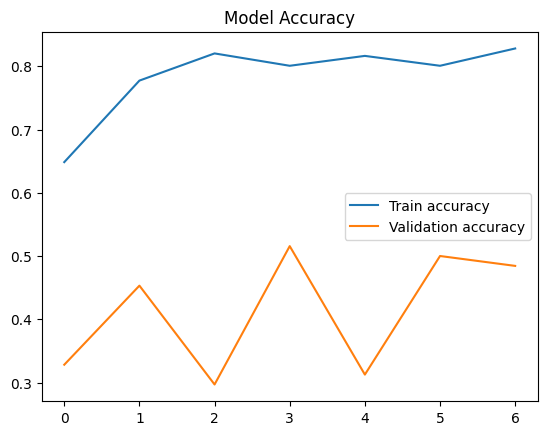

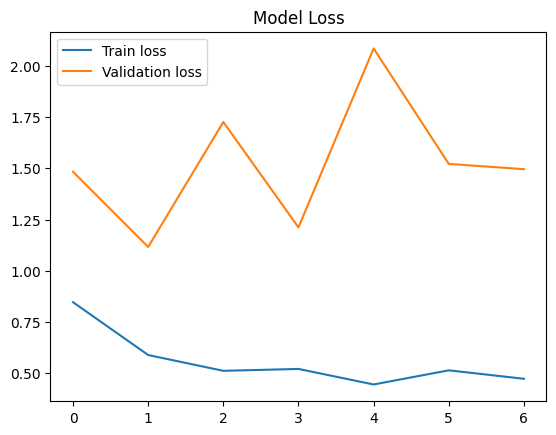

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Confusion Matrix:
[[ 8 11  0  0]
 [ 0 19  0  0]
 [ 0 11  2  0]
 [10  3  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        19
           2       0.43      1.00      0.60        19
           4       1.00      0.15      0.27        13
           9       0.00      0.00      0.00        13

    accuracy                           0.45        64
   macro avg       0.47      0.39      0.33        64
weighted avg       0.46      0.45      0.36        64



2026-02-18 16:38:42.566605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.p

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Learning curves
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# Confusion matrix and classification report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


The learning curves reveal a significant gap between training and validation performance, indicating overfitting.
While training accuracy reaches above 80%, validation accuracy remains around 45%, with highly unstable validation loss.

The confusion matrix highlights a strong class imbalance in predictions, with the model over-predicting class "2" and completely failing to recognize class "9".
These results suggest that the model capacity may be too high relative to the dataset size, leading to poor generalization despite regularization techniques.

To improve the results, several strategies could be explored. First, stronger regularization could be applied by reducing model capacity (e.g., decreasing the size of the dense layer), increasing dropout, or lowering the learning rate. Second, more aggressive data augmentation could help improve generalization. Finally, collecting more training data or using transfer learning with a pretrained model could significantly enhance performance and class balance.

## 3. Improvement 

Based on the previous evaluation, we introduce a revised architecture aimed at reducing overfitting and improving generalization under limited data conditions.

In [7]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Stronger data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

model2 = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize inputs
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # -------- Block 1 --------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 2 --------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 3 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 4 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    # Reduced dense layer (less capacity)
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

# Lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()


early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,030,532 (3.93 MB)

 Trainable params: 1,029,124 (3.93 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5352 - loss: 1.1659 - val_accuracy: 0.2969 - val_loss: 1.3490 - learning_rate: 1.0000e-04
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7109 - loss: 0.6366 - val_accuracy: 0.3906 - val_loss: 1.3481 - learning_rate: 1.0000e-04
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8086 - loss: 0.4856 - val_accuracy: 0.3281 - val_loss: 1.3750 - learning_rate: 1.0000e-04
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8359 - loss: 0.4711 - val_accuracy: 0.2969 - val_loss: 1.4168 - learning_rate: 1.0000e-04
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8242 - loss: 0.4633 - val_accuracy: 0.2969 - val_loss: 1.4690 - learning_rate: 1.0000e-04
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 990ms/step - accuracy: 0.8398 - loss: 0.4724 - val_accuracy: 0.2969 - val_loss: 1.5310 - learning_rate: 5.0000e-05
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8516 - lo

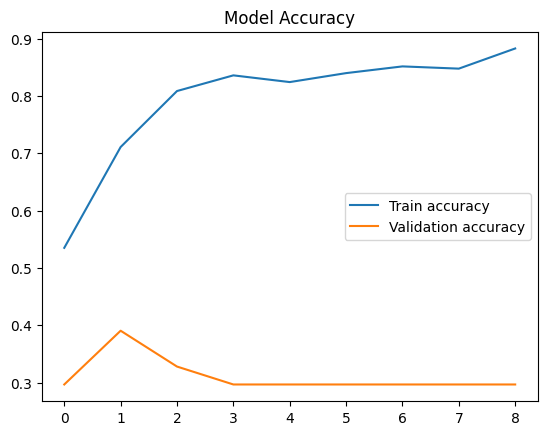

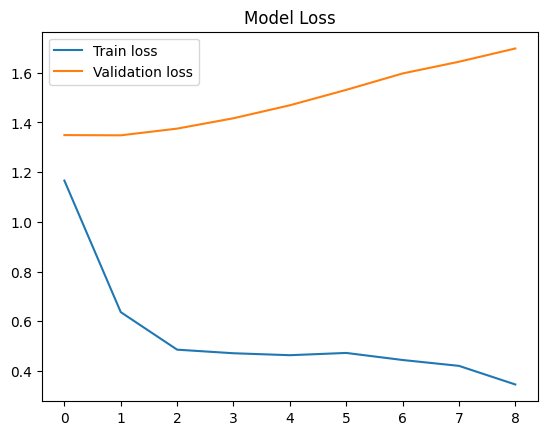

Confusion Matrix:
[[16  3  0  0]
 [10  9  0  0]
 [13  0  0  0]
 [13  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.84      0.45        19
           2       0.75      0.47      0.58        19
           4       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        13

    accuracy                           0.39        64
   macro avg       0.26      0.33      0.26        64
weighted avg       0.31      0.39      0.31        64



2026-02-18 16:53:54.910494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.p

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# =========================
# Learning curves
# =========================

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# =========================
# Confusion matrix
# =========================

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model2.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

# =========================
# Classification report
# =========================

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Despite reducing model capacity and strengthening regularization, the revised architecture does not significantly improve validation performance. The gap between training and validation accuracy remains substantial, and several classes (notably "4" and "9") are still poorly recognized.

These results suggest that the main limitation may not lie solely in model capacity, but rather in the extremely limited dataset size. In such a low-data regime, training a convolutional network from scratch appears unstable and prone to overfitting, even with architectural adjustments and optimization strategies.

This motivates the exploration of transfer learning, where pretrained representations may provide more robust and stable feature extraction under strong data constraints.

# II- Transfer Learning with DenseNet121

## 1. Architecture and Training

Given the overfitting observed when training a CNN from scratch, we now explore a transfer learning approach. 

We use a DenseNet121 model pretrained on ImageNet as a fixed feature extractor, and train only a small classification head on our dataset. This allows us to leverage rich pretrained representations while limiting the number of trainable parameters.

In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, Model, Input

# Load the DenseNet121 model without the top classification layer
# We use pre-trained weights from ImageNet to take advantage of transfer learning
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Freeze the pre-trained layers to avoid updating their weights during training
base_model.trainable = False

# Define the input layer for our new model
inputs = Input(shape=(128, 128, 3))

# Apply the preprocessing function required by DenseNet121
x = preprocess_input(inputs)

# Pass the inputs through the frozen DenseNet121 base
x = base_model(x, training=False)

# Add a global average pooling layer to reduce the output dimensions
x = layers.GlobalAveragePooling2D()(x)

# Add a dense layer to learn new features for our specific task
x = layers.Dense(256, activation='relu')(x)

# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)

# Add the final output layer with softmax activation for 4-class classification
outputs = layers.Dense(4, activation='softmax')(x)

# Create the complete model
densenet_model = Model(inputs, outputs)

# Compile the model using the Adam optimizer and a suitable loss for integer labels
densenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the architecture and number of parameters of the model
densenet_model.summary()

# Train the model on the same dataset as the custom CNN
history_densenet = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7109 - loss: 0.9572 - val_accuracy: 0.9219 - val_loss: 0.2235
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.9336 - loss: 0.1728 - val_accuracy: 0.9688 - val_loss: 0.0685
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 686ms/step - accuracy: 0.9844 - loss: 0.0585 - val_accuracy: 0.9688 - val_loss: 0.0661
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 680ms/step - accuracy: 0.9922 - loss: 0.0285 - val_accuracy: 0.9688 - val_loss: 0.0738
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 744ms/step - accuracy: 0.9961 - loss: 0.0181 - val_accuracy: 0.9688 - val_loss: 0.0853
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - accuracy: 0.9922 - loss: 0.0231 - val_accuracy: 0.9688 - val_loss: 0.0707
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 692ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9688 - val_loss: 0.0645
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 686ms/step - accuracy: 0.9961 - loss: 0.0189 - val_accurac

## 2. Model Evaluation and Performance Analysis

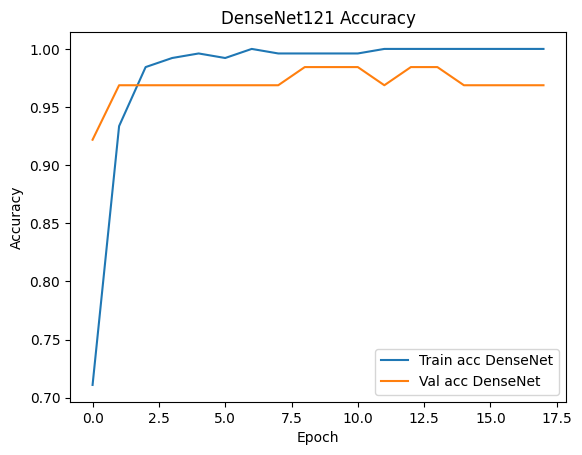

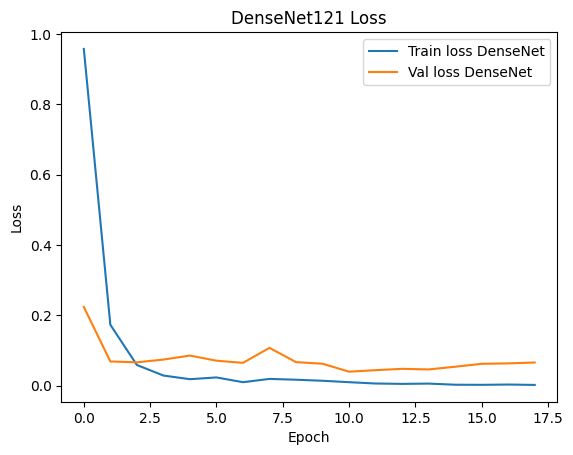

Confusion Matrix:
[[18  1  0  0]
 [ 0 19  0  0]
 [ 0  0 13  0]
 [ 0  0  0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           2       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13

    accuracy                           0.98        64
   macro avg       0.99      0.99      0.99        64
weighted avg       0.99      0.98      0.98        64



2026-02-18 17:01:25.038725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Plot the learning curves for DenseNet121
# This helps visualize how the training and validation accuracy and loss evolve over epochs

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# Accuracy curves
# =========================
plt.plot(history_densenet.history['accuracy'], label='Train acc DenseNet')
plt.plot(history_densenet.history['val_accuracy'], label='Val acc DenseNet')
plt.legend()
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# =========================
# Loss curves
# =========================
plt.plot(history_densenet.history['loss'], label='Train loss DenseNet')
plt.plot(history_densenet.history['val_loss'], label='Val loss DenseNet')
plt.legend()
plt.title("DenseNet121 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# =========================
# Confusion Matrix + Report
# =========================

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = densenet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


The DenseNet121-based model achieves strong and stable performance, with high validation accuracy (98%) and consistently low validation loss. The learning curves indicate rapid convergence and no significant generalization gap.

The confusion matrix confirms that all classes are correctly identified with high precision and recall, suggesting that the pretrained feature representations are well suited to this classification task.

These results demonstrate the effectiveness of transfer learning in a low-data setting, where leveraging pretrained visual features allows the model to achieve robust and reliable performance.


# III-Comparison Between Custom CNN and DenseNet121


## Which model is better?

The three experiments reveal a clear difference in behavior between training a CNN from scratch and using transfer learning.

The custom CNN models, despite architectural adjustments and stronger regularization, consistently exhibited overfitting. A significant gap between training and validation performance remained, and some classes were poorly recognized. These results suggest that learning visual features from scratch with a limited dataset leads to unstable generalization.

In contrast, the DenseNet121-based model achieved high validation accuracy (98%) with stable learning dynamics and strong performance across all classes. The pretrained backbone provides robust visual representations that generalize well even with limited training samples.

This comparison highlights a key insight: under strong data constraints, transfer learning is significantly more effective than training a deep convolutional architecture from scratch. Pretrained representations drastically reduce the need for large amounts of task-specific data while improving stability and class balance.

In [15]:
from pathlib import Path
from tensorflow.keras.preprocessing import image
import numpy as np

# Detect project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Define test image path (relative to project)
IMG_PATH = PROJECT_ROOT / "assets" / "test.jpg"

# Load and preprocess the test image
img = image.load_img(IMG_PATH, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# DenseNet preprocessing
img_array_densenet = preprocess_input(np.copy(img_array))

# Predict with custom CNN
pred_cnn = model2.predict(img_array)
pred_class_cnn = class_names[np.argmax(pred_cnn)]

# Predict with DenseNet121
pred_densenet = densenet_model.predict(img_array_densenet)
pred_class_densenet = class_names[np.argmax(pred_densenet)]

print("Custom CNN Prediction:", pred_class_cnn)
print("DenseNet121 Prediction:", pred_class_densenet)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Custom CNN Prediction: 0
DenseNet121 Prediction: 2


The CNN trained from scratch misclassified the test image, whereas the DenseNet121 model predicted the correct class. This confirms the previous analysis: the CNN overfitted due to the limited size of the training dataset relative to its model capacity (over one million parameters). In contrast, transfer learning provided more robust feature representations and better generalization on unseen data.